In [1]:
# VGG16 기반 접촉감지 Model 생성
# tensorflow 2.16.1 / keras 3.3.3

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input 
from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, GlobalAveragePooling2D

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.applications.imagenet_utils import decode_predictions 
import numpy as np
import math

In [3]:
TRAIN_DATA_DIR = './train/image'
VALIDATION_DATA_DIR = './valid/image'
TEST_DATA_DIR = './test/image'
 
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 64

In [4]:
# Input 데이터 가공
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2, 
                                   horizontal_flip=True, 
                                   vertical_flip=True)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(TRAIN_DATA_DIR,
                                                    target_size=(IMG_WIDTH,
                                                                 IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    seed=12345,
                                                    class_mode='categorical')
validation_generator = val_datagen.flow_from_directory(
    VALIDATION_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical')

Found 5753 images belonging to 2 classes.
Found 1652 images belonging to 2 classes.


In [5]:
def model_maker(num_train_layer):
    base_model = VGG16(weights='imagenet', include_top=False, 
                       input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)) # top 제외

    # fine tuning
    for layer in base_model.layers[:-(num_train_layer)]:
        layer.trainable = False # num_train_layer 값만큼의 층을 새롭게 학습 

    input1 = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    custom_model = base_model(input1)
    custom_model = GlobalAveragePooling2D()(custom_model)
    custom_model = Dense(64, activation='relu')(custom_model)
    predictions = Dense(2, activation='softmax')(custom_model) 
    return Model(inputs=input1, outputs=predictions)

In [6]:
# train Model

checkpoint_filepath = "./model0_layer3_monitorLoss_Adam.keras"
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)
mc = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', mode='min', save_best_only=True)

num_train_layer = 3
model = model_maker(num_train_layer)

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['acc'])
history=model.fit(
    train_generator,
    epochs= 200,
    validation_data=validation_generator, callbacks=[es, mc])

Epoch 1/200


C:\Users\hybyu\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


90/90 ━━━━━━━━━━━━━━━━━━━━ 591s 6s/step - acc: 0.6712 - loss: 5.8602 - val_acc: 0.8487 - val_loss: 0.5676
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 492s 5s/step - acc: 0.8083 - loss: 0.5219 - val_acc: 0.8245 - val_loss: 0.4267
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 492s 5s/step - acc: 0.8035 - loss: 0.4801 - val_acc: 0.8535 - val_loss: 0.4371
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 492s 5s/step - acc: 0.8291 - loss: 0.4213 - val_acc: 0.8354 - val_loss: 0.4430
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 491s 5s/step - acc: 0.8277 - loss: 0.4229 - val_acc: 0.7954 - val_loss: 0.4541
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 492s 5s/step - acc: 0.8404 - loss: 0.3818 - val_acc: 0.8408 - val_loss: 0.3780
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 491s 5s/step - acc: 0.8324 - loss: 0.4252 - val_acc: 0.8826 - val_loss: 0.3355
Epoch 8/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 492s 5s/step - acc: 0.8564 - loss: 0.3535 - val_acc: 0.8856 - val_loss: 0.3497
Epoch 9/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 492s 5s/step - acc: 0.8537 - 

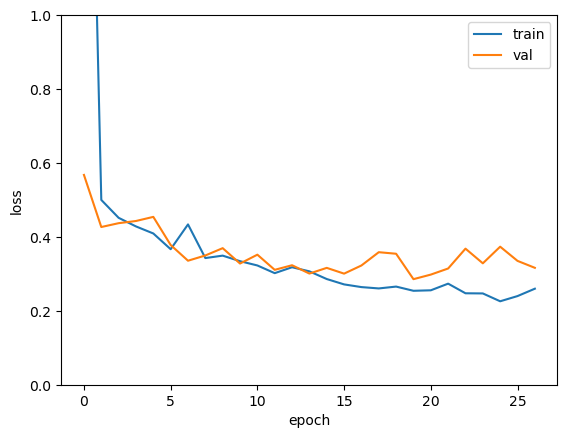

In [7]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.ylim([0, 1])  
plt.show()

In [8]:
# test Model
test_generator = val_datagen.flow_from_directory(
    TEST_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical')

best_model = models.load_model(checkpoint_filepath) # best model 불러오기
model = best_model

model.evaluate(test_generator, steps=math.ceil(float(825 / BATCH_SIZE)),verbose=1) 

Found 825 images belonging to 2 classes.
13/13 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step - acc: 0.9168 - loss: 0.2333


[0.3541105091571808, 0.8690909147262573]

In [9]:
# train Model

checkpoint_filepath = "./model0_layer5_monitorLoss_Adam.keras"
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)
mc = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', mode='min', save_best_only=True)

num_train_layer = 5
model = model_maker(num_train_layer)

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['acc'])
history=model.fit(
    train_generator,
    epochs= 200,
    validation_data=validation_generator, callbacks=[es, mc])

Epoch 1/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 513s 6s/step - acc: 0.6454 - loss: 13.2629 - val_acc: 0.8462 - val_loss: 0.4613
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 511s 6s/step - acc: 0.8047 - loss: 0.4781 - val_acc: 0.8123 - val_loss: 0.4569
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 512s 6s/step - acc: 0.8057 - loss: 0.4803 - val_acc: 0.7893 - val_loss: 0.4704
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 511s 6s/step - acc: 0.8010 - loss: 0.4784 - val_acc: 0.8299 - val_loss: 0.4284
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 510s 6s/step - acc: 0.8228 - loss: 0.4193 - val_acc: 0.8608 - val_loss: 0.3906
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 510s 6s/step - acc: 0.8428 - loss: 0.3866 - val_acc: 0.8650 - val_loss: 0.4018
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 510s 6s/step - acc: 0.8541 - loss: 0.3604 - val_acc: 0.8699 - val_loss: 0.3445
Epoch 8/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 509s 6s/step - acc: 0.8700 - loss: 0.3287 - val_acc: 0.8741 - val_loss: 0.3633
Epoch 9/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 509s 6s/step - a

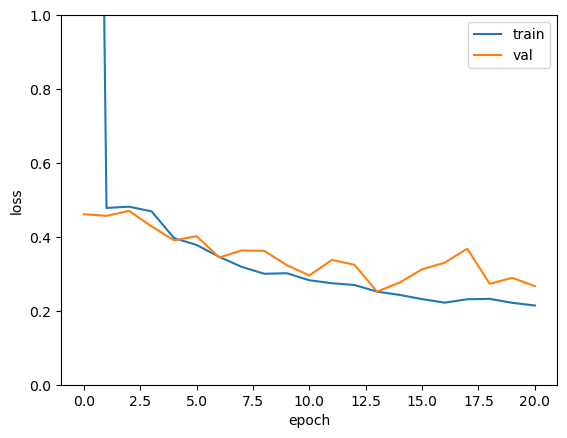

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.ylim([0, 1])  
plt.show()

In [11]:
# test Model
test_generator = val_datagen.flow_from_directory(
    TEST_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical')

best_model = models.load_model(checkpoint_filepath) # best model 불러오기
model = best_model

model.evaluate(test_generator, steps=math.ceil(float(825 / BATCH_SIZE)),verbose=1) 

Found 825 images belonging to 2 classes.
13/13 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - acc: 0.9311 - loss: 0.1744


[0.3268928527832031, 0.8521212339401245]

In [12]:
# train Model

checkpoint_filepath = "./model0_layer3_monitorLoss_RMSprop.keras"
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)
mc = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', mode='min', save_best_only=True)

num_train_layer = 3
model = model_maker(num_train_layer)

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(0.001),
              metrics=['acc'])
history=model.fit(
    train_generator,
    epochs= 200,
    validation_data=validation_generator, callbacks=[es, mc])

Epoch 1/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 493s 5s/step - acc: 0.6749 - loss: 83.4762 - val_acc: 0.8487 - val_loss: 0.7491
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 489s 5s/step - acc: 0.7459 - loss: 0.6675 - val_acc: 0.8487 - val_loss: 0.4823
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 489s 5s/step - acc: 0.7897 - loss: 0.5220 - val_acc: 0.8232 - val_loss: 0.3934
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 490s 5s/step - acc: 0.8103 - loss: 0.5210 - val_acc: 0.7778 - val_loss: 0.5389
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 489s 5s/step - acc: 0.8270 - loss: 0.4333 - val_acc: 0.8529 - val_loss: 0.4216
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 489s 5s/step - acc: 0.8383 - loss: 0.4094 - val_acc: 0.8553 - val_loss: 0.3408
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 489s 5s/step - acc: 0.8222 - loss: 0.4183 - val_acc: 0.8741 - val_loss: 0.3362
Epoch 8/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 489s 5s/step - acc: 0.8585 - loss: 0.4075 - val_acc: 0.8505 - val_loss: 0.3663
Epoch 9/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 489s 5s/step - a

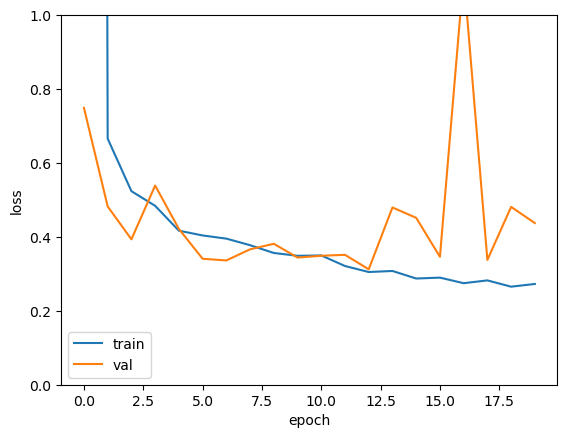

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.ylim([0, 1])  
plt.show()

In [14]:
# test Model
test_generator = val_datagen.flow_from_directory(
    TEST_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical')

best_model = models.load_model(checkpoint_filepath) # best model 불러오기
model = best_model

model.evaluate(test_generator, steps=math.ceil(float(825 / BATCH_SIZE)),verbose=1) 

Found 825 images belonging to 2 classes.
13/13 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - acc: 0.9387 - loss: 0.2305


[0.3974653482437134, 0.8581818342208862]